# Data z tramvají DPO
### Zkoumání pro korelaci s realitou

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import tconsumption
from tconsumption import Consumption, G_TO_MS2
import matplotlib.pyplot as plt
from scipy.signal import hilbert, argrelextrema
import ruptures as rpt
import importlib

In [2]:
def remove_leader(path: str):
    return path.split(".")[-1]

def convert_sig_unsig(number):
    if number < 32767:
        return number
    else:
        return number-65535

def tram_csv_parser(csv_path):
    # Load from csv
    df = pd.read_csv(csv_path, delimiter=";", skiprows=73, decimal=",")
    default_cols = list(df.columns)

    # Rename cols
    rename_dict = {}
    for col in df.columns:
        new_name = remove_leader(col)
        rename_dict[col] = new_name
    df.rename(columns=rename_dict, inplace=True)

    # New cols (calculated)
    # Time
    df.insert(2, "DateTime", pd.to_datetime(df["Date"] + ' ' + df["Time"], format="%d.%m.%Y %H:%M:%S:%f"))
    del df["Date"]
    del df["Time"]
    df["delta_T"] = df["DateTime"].diff(periods=-1).abs()

    # Trakcni menic 1
    df["tm_stejnoproud_trakce"] = df["AM_A_C1_14_IwTCU_ILF1"].apply(convert_sig_unsig)/10
    df["tm_stejnoproud_spotrebice"] = df["AM_A_C1_14_IwAUX_I_DClink"]*0.1
    df["tm_stridaproud_vystupu"] = df["AM_A_C1_14_IwAUX_I_rms"]*0.01
    df["tm_vstupni_napeti"] = df["AM_A_C1_14_IwTCU_UD1Voltage"]/10
    df["tm_tah_vyvijeny_motory"] = df["AM_B_C1_15_IwTCU_E_MC1"].apply(convert_sig_unsig)/100
    df["tm_rychlost_3_napravy"] = df["VrTCU_A_A1_Velocity"]/3.6
    df["tm_prikon_trakce"] = df["tm_stejnoproud_trakce"]*df["tm_vstupni_napeti"]/1000
    df["tm_vykon_trakce"] = df["tm_tah_vyvijeny_motory"]*df["tm_rychlost_3_napravy"]
    df["tm_prikon_spotrebice"] = df["AM_A_C1_14_IwTCU_P_AUX"]/100
    df["tm_prikon_topeni_klima"] = 1.73*400*df["tm_stridaproud_vystupu"]/1000
    df["tm_vykon_zmareny"] = np.where((df["tm_vykon_trakce"] > 0) & (df["tm_vykon_trakce"] < df["tm_prikon_trakce"]), df["tm_prikon_trakce"]-df["tm_vykon_trakce"], 0)

    # Trakcni menic 2
    df["tm2_stejnoproud_trakce"] = df["AM_B_C1_15_IwTCU_ILF1"].apply(convert_sig_unsig)/10
    df["tm2_vstupni_napeti"] = df["AM_B_C1_15_IwTCU_UD1Voltage"]/10
    df["tm2_tah_vyvijeny_motory"] = df["AM_B_C1_15_IwTCU_E_MC1"].apply(convert_sig_unsig)/100
    df["tm2_rychlost_5_napravy"] = df["VrTCU_B_A1_Velocity"]/3.6
    df["tm2_prikon_trakce"] = df["tm2_stejnoproud_trakce"]*df["tm2_vstupni_napeti"]/1000
    df["tm2_vykon_trakce"] = df["tm2_tah_vyvijeny_motory"]*df["tm2_rychlost_5_napravy"]
    df["tm2_vykon_zmareny"] = np.where((df["tm2_vykon_trakce"] > 0) & (df["tm2_vykon_trakce"] < df["tm2_prikon_trakce"]), df["tm2_prikon_trakce"]-df["tm2_vykon_trakce"], 0)

    # Cela tramvaj
    df["cela_vykon_spotrebovany"] = np.where(df["tm_prikon_trakce"]+df["tm_prikon_spotrebice"]+df["tm2_prikon_trakce"] > 0, df["tm_prikon_trakce"]+df["tm_prikon_spotrebice"]+df["tm2_prikon_trakce"], 0)
    df["cela_vykon_spotrebovany_bez_spotrebicu"] = np.where(df["tm_prikon_trakce"]+df["tm2_prikon_trakce"] > 0, df["tm_prikon_trakce"]+df["tm2_prikon_trakce"], 0)
    df["cela_vykon_rekuperovany"] = np.where(df["tm_prikon_trakce"]+df["tm_prikon_spotrebice"]+df["tm2_prikon_trakce"] < 0, -(df["tm_prikon_trakce"]+df["tm_prikon_spotrebice"]+df["tm2_prikon_trakce"]), 0)
    df["cela_vykon_rekuperovany_bez_spotrebicu"] = np.where(df["tm_prikon_trakce"]+df["tm2_prikon_trakce"] < 0, -(df["tm_prikon_trakce"]+df["tm2_prikon_trakce"]), 0)
    df["cela_vykon_zmareny"] = df["tm_vykon_zmareny"]+df["tm2_vykon_zmareny"]
    df["cela_vykon_trakce"] = df["tm_vykon_trakce"]+df["tm2_vykon_trakce"]
    df["cela_prikon_topeni_klima"] = df["tm_prikon_topeni_klima"]

    df["cela_energie_spotrebovana"] = (df["cela_vykon_spotrebovany"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_spotrebovana"] = 0.0

    df["cela_energie_spotrebovana_bez_spotrebicu"] = (df["cela_vykon_spotrebovany_bez_spotrebicu"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_spotrebovana_bez_spotrebicu"] = 0.0

    df["cela_energie_rekuperovana"] = (df["cela_vykon_rekuperovany"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_rekuperovana"] = 0.0

    df["cela_energie_rekuperovana_bez_spotrebicu"] = (df["cela_vykon_rekuperovany_bez_spotrebicu"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_rekuperovana_bez_spotrebicu"] = 0.0

    df["cela_energie_zmarena"] = (df["cela_vykon_zmareny"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_zmarena"] = 0.0

    df["cela_energie_topeni_klima"] = (df["cela_prikon_topeni_klima"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_topeni_klima"] = 0.0

    df["cela_vykon_vyrovnany_bez_spotrebicu"] = df["cela_vykon_spotrebovany_bez_spotrebicu"]-df["cela_vykon_rekuperovany_bez_spotrebicu"]
    df["cela_energie_vyrovnana_bez_spotrebicu"] = df["cela_energie_spotrebovana_bez_spotrebicu"]-df["cela_energie_rekuperovana_bez_spotrebicu"]

    df["km_total"] = df["QdwMesitTotalDistance"]*0.1

    return df
    return default_cols

"""
{
    "TYPE": "LineString",
    "coordinates": [
        [100.0, 0.0],
        [101.0, 1.0]
    ]
}
"""
def make_geojson(lat, long):
    geojson = {
        "type": "LineString",
    }
    geojson["coordinates"] = list(zip(long, lat))
    return json.dumps(geojson)

In [3]:
df = tram_csv_parser("../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/01-Vozovna-Vresinska_2022-04-20.csv")

In [4]:
df_important = df[[
    "DateTime", "delta_T", "VrGpsLatitude", "VrGpsLongitude",
    "km_total", "tm_rychlost_3_napravy", "tm2_rychlost_5_napravy",
    "cela_vykon_spotrebovany_bez_spotrebicu", "cela_vykon_rekuperovany_bez_spotrebicu",
    "cela_energie_spotrebovana_bez_spotrebicu", "cela_energie_rekuperovana_bez_spotrebicu"
]]

df_important["cela_vykon_vyrovnany_bez_spotrebicu"] = df_important["cela_vykon_spotrebovany_bez_spotrebicu"]-df_important["cela_vykon_rekuperovany_bez_spotrebicu"]
df_important["cela_energie_vyrovnana_bez_spotrebicu"] = df_important["cela_energie_spotrebovana_bez_spotrebicu"]-df_important["cela_energie_rekuperovana_bez_spotrebicu"]

geojson = make_geojson(df_important["VrGpsLatitude"],df_important["VrGpsLongitude"])
with open("/tmp/test.geojson", "w") as f:
    f.write(geojson)

/tmp/ipykernel_19931/3941359690.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_important["cela_vykon_vyrovnany_bez_spotrebicu"] = df_important["cela_vykon_spotrebovany_bez_spotrebicu"]-df_important["cela_vykon_rekuperovany_bez_spotrebicu"]
/tmp/ipykernel_19931/3941359690.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_important["cela_energie_vyrovnana_bez_spotrebicu"] = df_important["cela_energie_spotrebovana_bez_spotrebicu"]-df_important["cela_energie_rekuperovana_bez_spotrebicu"]


<Axes: xlabel='km_total'>

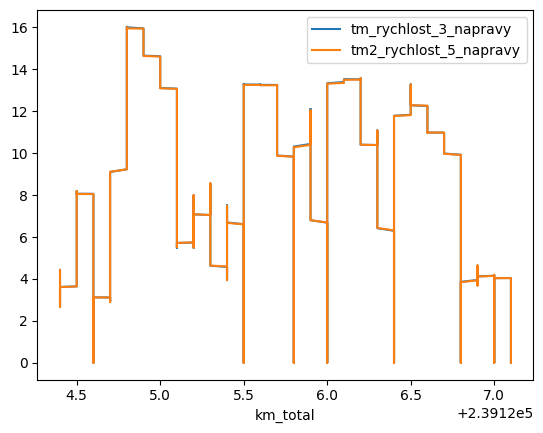

In [5]:
df_important.plot(x="km_total", y=["tm_rychlost_3_napravy", "tm2_rychlost_5_napravy"])

In [33]:
df_important.head()

,DateTime,delta_T,VrGpsLatitude,VrGpsLongitude,km_total,tm_rychlost_3_napravy,tm2_rychlost_5_napravy,cela_vykon_spotrebovany_bez_spotrebicu,cela_vykon_rekuperovany_bez_spotrebicu,cela_energie_spotrebovana_bez_spotrebicu,cela_energie_rekuperovana_bez_spotrebicu,cela_vykon_vyrovnany_bez_spotrebicu,cela_energie_vyrovnana_bez_spotrebicu
0,2022-04-20 08:54:54.184,0 days 00:00:00.100000,49.83483,18.17648,239124.4,4.431147,4.422394,5.10375,0.00000,0.000000,0.000000,5.10375,0.000000
1,2022-04-20 08:54:54.284,0 days 00:00:00.099000,49.83483,18.17648,239124.4,4.431147,4.428036,4.81806,0.00000,0.000142,0.000000,4.81806,0.000142
2,2022-04-20 08:54:54.383,0 days 00:00:00.101000,49.83483,18.17648,239124.4,4.425467,4.419575,0.00000,13.73600,0.000274,0.000000,-13.73600,0.000274
3,2022-04-20 08:54:54.484,0 days 00:00:00.100000,49.83483,18.17648,239124.4,4.402742,4.405472,0.00000,37.26192,0.000274,0.000385,-37.26192,-0.000111
4,2022-04-20 08:54:54.584,0 days 00:00:00.100000,49.83483,18.17648,239124.4,4.380019,4.380089,0.00000,28.73187,0.000274,0.001420,-28.73187,-0.001146


In [34]:
max_velocities = None

Max power from measured data: 598.9970400000001
[] 19


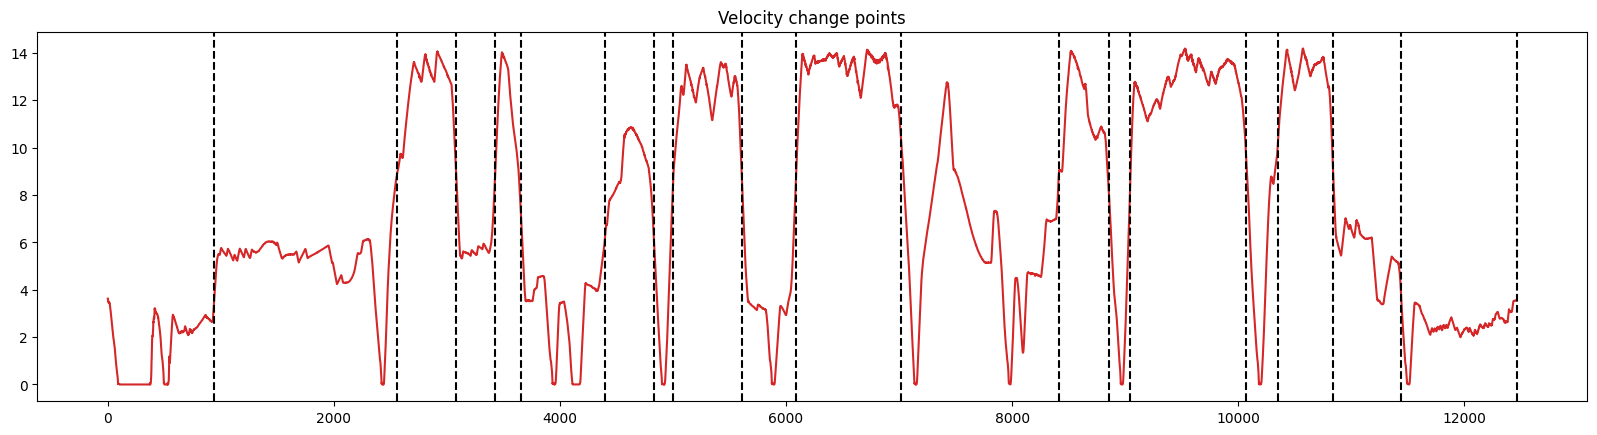

670
1245
736
726
1161
902
1120
663
1268
Simulation final energy: 15.671347132633763
Real final energy: 19.862349672311073


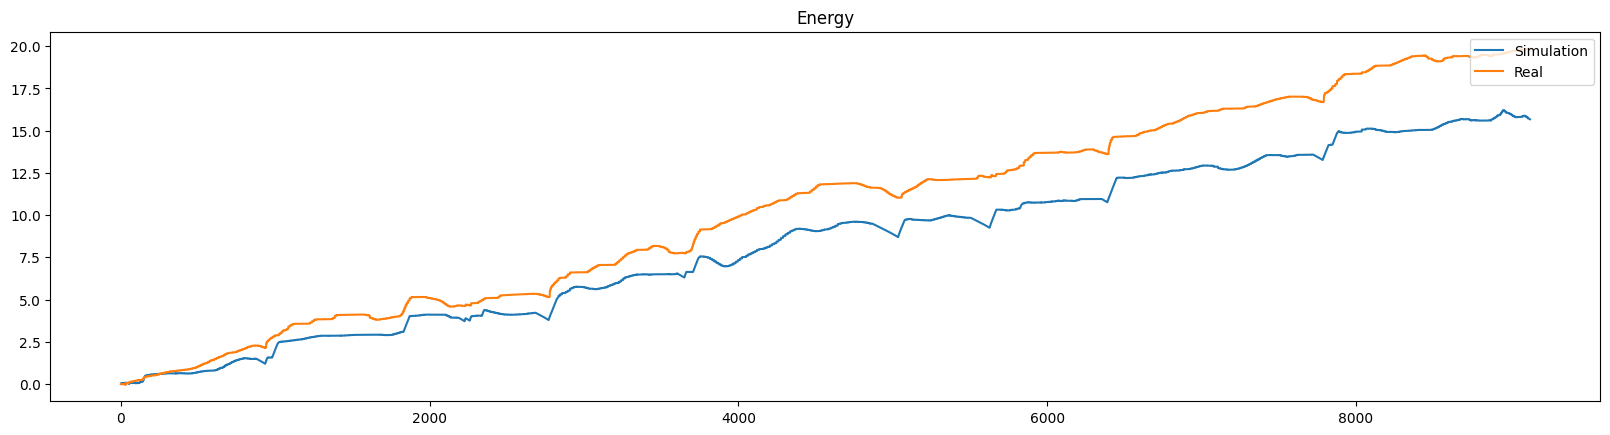

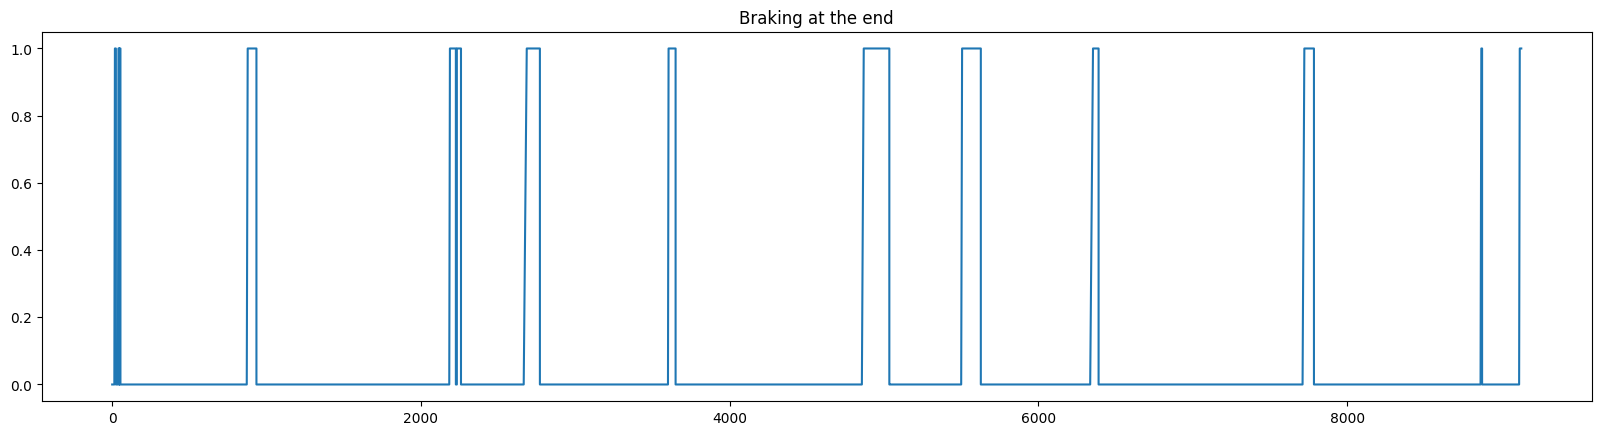

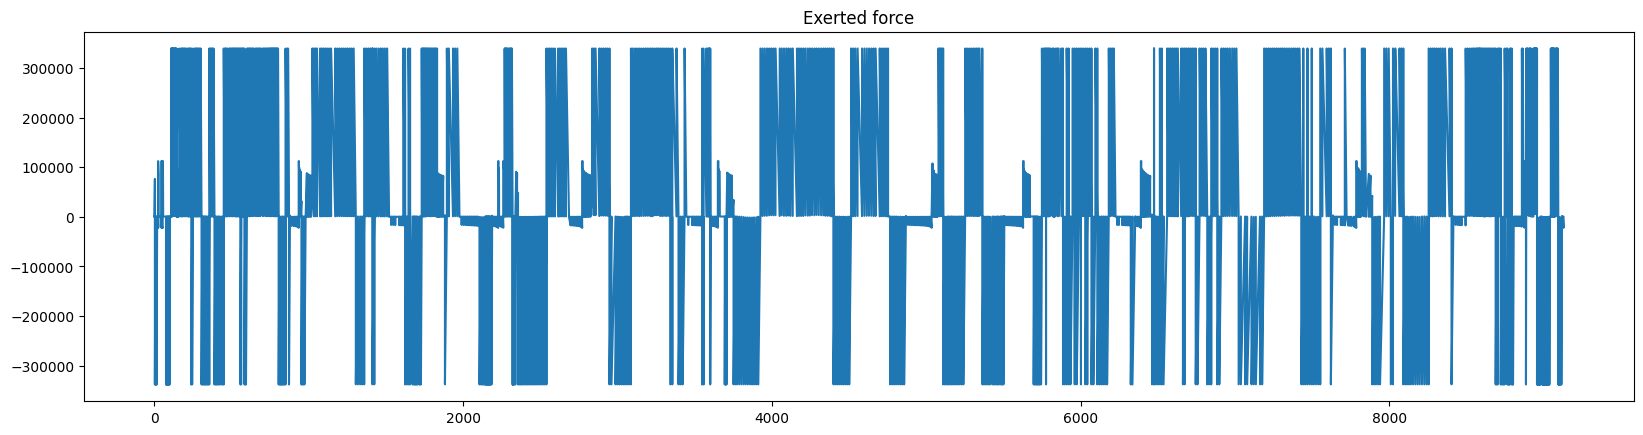

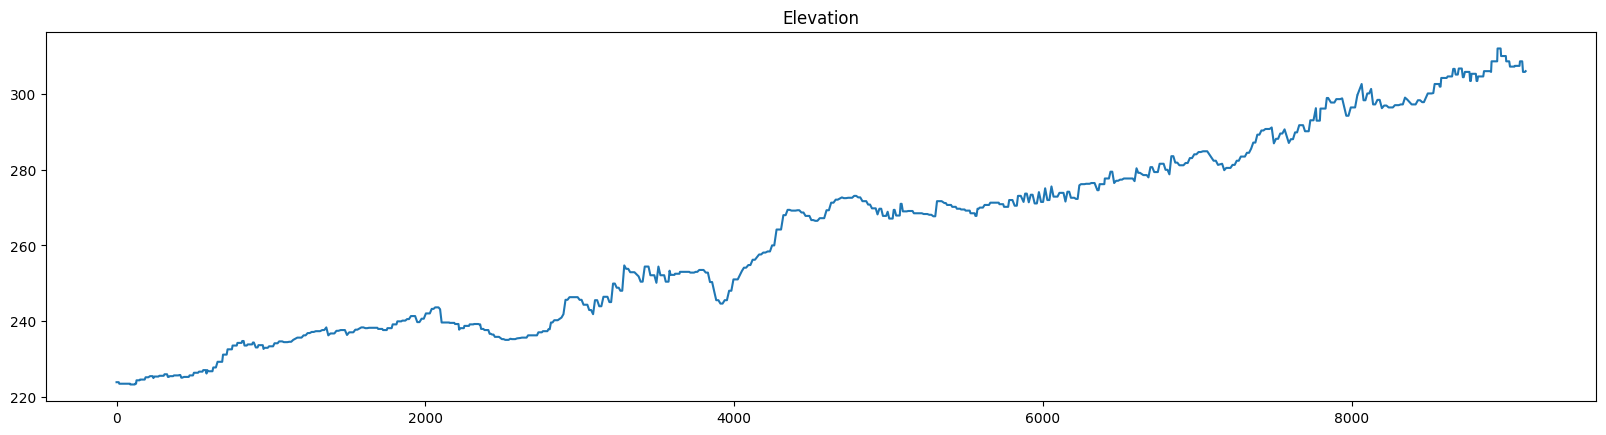

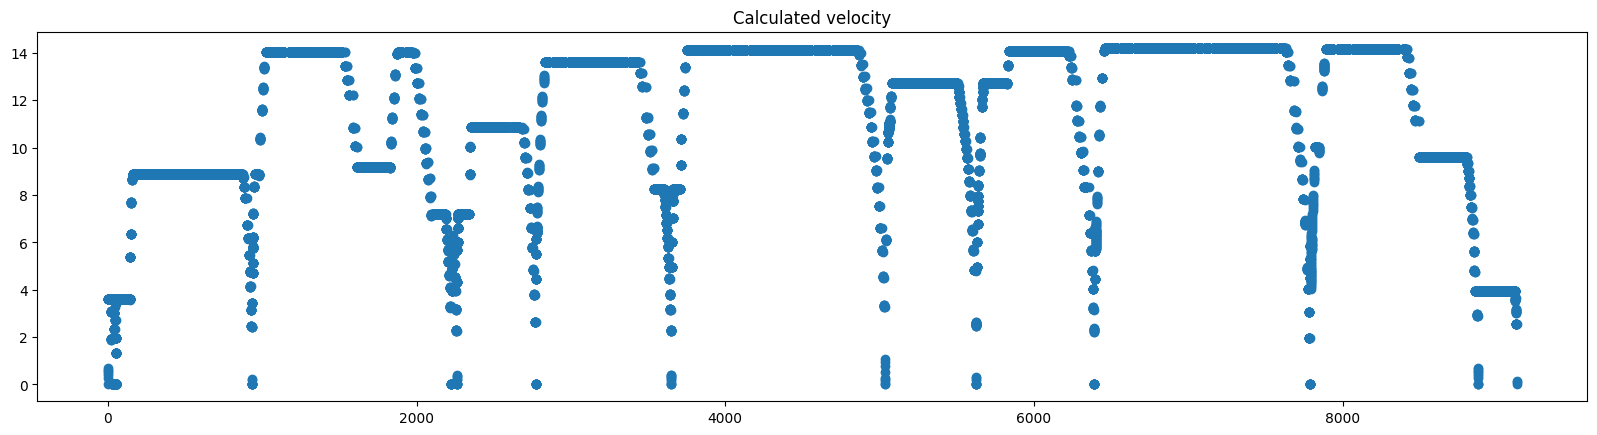

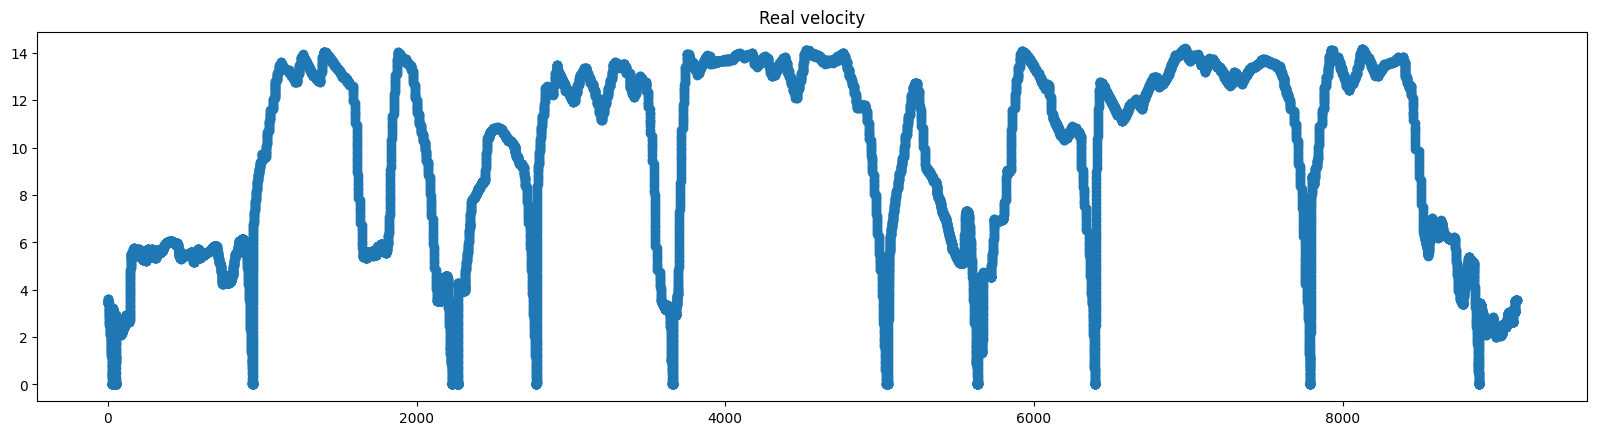

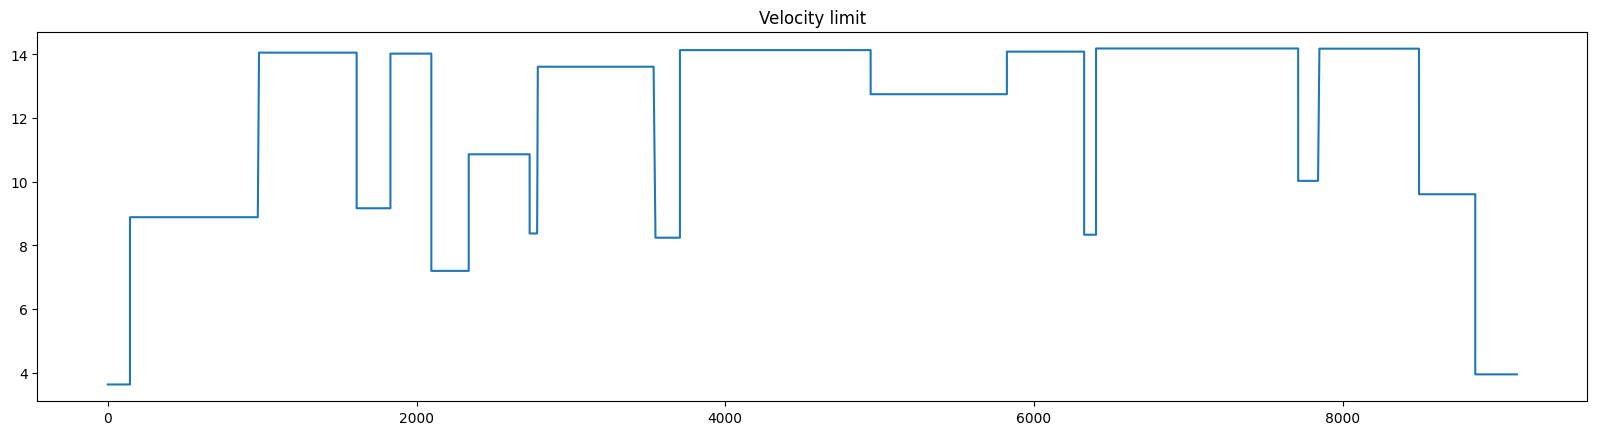

{'force_values': [0,
  338329.425,
  337872.29382991465,
  337872.06754284585,
  337871.86751152104,
  337871.6810770977,
  337871.5033335097,
  76267.62258995589,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  118.93365544904151,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  106.53606106234662,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  106.53615736089796,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,
  -67570.02155624876,


In [35]:
importlib.reload(tconsumption)
def compare_data(csv_path: str, geojson_path: str):
    # Calculated data
    c = Consumption()
    c.params["mass_locomotive"] = 34500
    c.variable_params["Recuperation coefficient"] = 0.2
    c.load_from_file(geojson_path)

    # Measured data
    df = tram_csv_parser(csv_path)

    # Modifying some parameters
    print("Max power from measured data:", df["cela_vykon_vyrovnany_bez_spotrebicu"].max())
    # c.params["power_limit"] = None
    c.params["power_limit"] = 600*1000
    # c.params["acceleration_limit"] = 1*G_TO_MS2

    # Inferring stops
    stations_stopped = []
    last_row_zero = 0
    for i,row in enumerate(df["tm_rychlost_3_napravy"]):
        if row < 1:
            if last_row_zero < i-1:
                stations_stopped.append(i)
            last_row_zero = i
    c.stations = [c.stations[0]] + stations_stopped + [c.stations[-1]]

    # Getting velocity segments
    global max_velocities
    if max_velocities is None:
        algo = rpt.Pelt(model="rbf").fit(df["tm_rychlost_3_napravy"].values)
        result = algo.predict(pen=100)

        to_remove = []
        for i,r in enumerate(result):
            if i == 0:
                continue
            slice = df["tm_rychlost_3_napravy"][result[i-1]:r]
            if len(slice)/2 < len([x for x in slice if x == 0]):
                to_remove.append(i-1)
        to_remove.reverse()
        print(to_remove, len(result))
        for i in to_remove:
            del result[i]

        fig, ax = plt.subplots()
        fig.set_figwidth(20)
        ax.plot(list(df["tm_rychlost_3_napravy"]), color="tab:red")
        plt.title("Velocity change points")
        for r in result:
            ax.axvline(x=r, color="k", linestyle="--")
        plt.show()

        max_velocities = []
        for i,r in enumerate(result):
            if i == 0:
                segment = df["tm_rychlost_3_napravy"][:r]
            else:
                segment = df["tm_rychlost_3_napravy"][result[i-1]:r]
            max_velocities += [max(segment)] * len(segment)

    c.max_velocities_in_mps = max_velocities

    # Running the simulation
    c.run()

    # Plotting
    energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
    energy_real = df["cela_energie_vyrovnana_bez_spotrebicu"]
    print(f"Simulation final energy: {energy_calculated[-1]}")
    print(f"Real final energy: {energy_real.iloc[-1]}")

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], energy_calculated)
    plt.plot(c.series["dist_values"], energy_real)
    plt.title("Energy")
    plt.legend(["Simulation", "Real"], loc ="upper right")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], c.series["braking_at_the_end"])
    plt.title("Braking at the end")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], c.series["exerted_force_values"])
    plt.title("Exerted force")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], [x[2] for x in c.points])
    plt.title("Elevation")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.scatter(c.series["dist_values"], c.series["velocity_values"])
    plt.title("Calculated velocity")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.scatter(c.series["dist_values"], list(df["tm_rychlost_3_napravy"]))
    plt.title("Real velocity")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], c.max_velocities_in_mps)
    plt.title("Velocity limit")
    plt.show()

    return c.series

compare_data(
    "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/01-Vozovna-Vresinska_2022-04-20.csv",
    "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/01-Vozovna-Vresinska_2022-04-20.geojson"
)

# compare_data(
#     "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/02-Vresinska-Zatisi_2022-04-20.csv",
#     "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/02-Vresinska-Zatisi_2022-04-20.geojson"
# )

# compare_data(
#     "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/03-Zatisi-Vresinska_2022-04-20.csv",
#     "../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/03-Zatisi-Vresinska_2022-04-20.geojson"
# )